In [4]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS
using StellarOpacity
using StellarEvolution

In [5]:
function equationHSE(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                            κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnP₀ = var00[sm.vari[:lnP]]
        r₀ = exp(var00[sm.vari[:lnr]])
        g₀ = CGRAV*sm.mstar/r₀^2
        return lnP₀ -log(2g₀/(3κ00)) # Eddington gray, ignoring radiation pressure term
    end
    lnP₊ = varp1[sm.vari[:lnP]]
    lnP₀ = var00[sm.vari[:lnP]]
    lnPface = (sm.dm[k]*lnP₀ + sm.dm[k+1]*lnP₊)/(sm.dm[k]+sm.dm[k+1])
    r₀ = exp(var00[sm.vari[:lnr]])
    dm = (sm.m[k+1]-sm.m[k])
    
    return (exp(lnPface)*(lnP₊ - lnP₀)/dm + CGRAV*sm.m[k]/(4π*r₀^4))/(CGRAV*sm.m[k]/(4π*r₀^4))
end

function equationT(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    if k==sm.nz
        lnT₀ = var00[sm.vari[:lnT]]
        L₀ = var00[sm.vari[:lum]]*LSUN
        r₀ = exp(var00[sm.vari[:lnr]])
        return lnT₀ - log(L₀/(BOLTZ_SIGMA*4π*r₀^2))/4 # Eddington gray, ignoring radiation pressure term
    end
    κface = exp((sm.dm[k]*log(κ00) + sm.dm[k+1]*log(κp1))/(sm.dm[k]+sm.dm[k+1]))
    L₀ = var00[sm.vari[:lum]]*LSUN
    r₀ = exp(var00[sm.vari[:lnr]])
    Pface = exp((sm.dm[k]*var00[sm.vari[:lnP]] + sm.dm[k+1]*varp1[sm.vari[:lnP]])/(sm.dm[k]+sm.dm[k+1]))
    lnT₊ = varp1[sm.vari[:lnT]]
    lnT₀ = var00[sm.vari[:lnT]]
    Tface = exp((sm.dm[k]*lnT₀ + sm.dm[k+1]*lnT₊)/(sm.dm[k]+sm.dm[k+1]))

    ∇ᵣ = 3κface*L₀*Pface/(16π*CRAD*CLIGHT*CGRAV*sm.m[k]*Tface^4)

    return (Tface*(lnT₊ - lnT₀)/sm.dm[k] + CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)*∇ᵣ)/(CGRAV*sm.m[k]*Tface/(4π*r₀^4*Pface)) # only radiative transport
end

function equationLuminosity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                          eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                          κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    L₋::TT = 0 # central luminosity is zero at first cell
    if k>1
        L₋ = varm1[sm.vari[:lum]]*LSUN # change it if not at first cell
    end
    L₀ = var00[sm.vari[:lum]]*LSUN
    ρ₀ = eos00[1]
    cₚ = eos00[5]
    δ = eos00[6]
    dTdt = (exp(var00[sm.vari[:lnT]]) - exp(sm.ssi.lnT_old[k]))/sm.ssi.dt
    dPdt = (exp(var00[sm.vari[:lnP]]) - exp(sm.ssi.lnP_old[k]))/sm.ssi.dt
    return ((L₀-L₋)/sm.dm[k]+cₚ*dTdt -(δ/ρ₀)*dPdt) # no nuclear reactions or neutrinos
end

function equationContinuity(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                   eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                   κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    ρ₀ = eos00[1]
    r₀ = exp(var00[sm.vari[:lnr]])
    r₋::TT = 0 # central radius is zero at first cell
    if k>1
        r₋ = exp(varm1[sm.vari[:lnr]]) # change it if not at first cell
    end
    
    dm = sm.m[k] # this is only valid for k=1
    if k>1
        dm = dm-sm.m[k-1]
    end

    #expected_r₀ = r₋ + dm/(4π*r₋^2*ρ)
    expected_dr³_dm = 3/(4π*ρ₀)
    actual_dr³_dm = (r₀^3-r₋^3)/dm
    
    return (expected_dr³_dm - actual_dr³_dm)*ρ₀
end

#  To test performance, include 8 isotopes similar to basic.net in MESA.
#  of course we are keeping these fixed now, but it lets us test their impact on the
#  computation of the jacobian

function equationH1(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:H1]] - 1.0
end

function equationHe3(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:He3]] - 0.0
end

function equationHe4(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:He4]] - 0.0
end

function equationC12(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:C12]] - 0.0
end

function equationN14(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:N14]] - 0.0
end

function equationO16(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:O16]] - 0.0
end

function equationNe20(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:Ne20]] - 0.0
end

function equationMg24(sm, k, varm1::Vector{<:TT}, var00::Vector{<:TT}, varp1::Vector{<:TT},
                                    eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT},
                                    κm1::TT, κ00::TT, κp1::TT)::TT where{TT<:Real}
    return var00[sm.vari[:Mg24]] - 0.0
end

equationMg24 (generic function with 1 method)

In [10]:
nvars = 12
nspecies = 8
varnames = [:lnP,:lnT,:lnr,:lum,:H1, :He3, :He4, :C12, :N14, :O16, :Ne20, :Mg24]
structure_equations=[equationHSE, equationT,
                        equationContinuity, equationLuminosity,
                        equationH1, equationHe3, equationHe4, equationC12, equationN14, equationO16, equationNe20, equationMg24]
nz = 1000
eos = StellarEOS.IdealEOS(false)
opacity = StellarOpacity.SimpleElectronScatteringOpacity()
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos, opacity);

In [11]:
# use an n=1 polytrope as initial condition, should be better than a constant density star
using ForwardDiff
using Roots

isotope_list = StellarChem.get_isotope_list()

function theta_n(xi)
    return sin(xi)/xi
end

M = MSUN
R = RSUN
n=1

# create a profile for composition that better resolves edges
function get_logdq(k, nz, logdq_low, logdq_high, numregion)
    if k<numregion
        return logdq_low+(k-1)*(logdq_high - logdq_low)/(numregion-1)
    elseif k<nz-numregion
        return logdq_high
    else
        k0 = nz-numregion
        k1 = nz
        return logdq_high+(logdq_low-logdq_high)*(k-k0)/(k1-k0)
    end
end
logdqs = get_logdq.(1:sm.nz,sm.nz,-3.0,0.0,100)
dqs = 10 .^ logdqs
dqs = dqs./sum(dqs)
dms = dqs.*M
m_face = cumsum(dms)
m_cell = cumsum(dms)
#correct m_center
for i in 1:sm.nz
    if i==1
        m_cell[i] = 0
    elseif i!=sm.nz
        m_cell[i] = m_cell[i] - 0.5*dms[i]
    end
end

rn = R/π # ξ is defined as r/rn, where rn^2=(n+1)Pc/(4π G ρc^2)

ρc = M/(4π*rn^3*(-π^2*ForwardDiff.derivative(theta_n, π)))
Pc = 4π*CGRAV*rn^2*ρc^2/(n+1)

@show ρc, Pc

ξ_cell = zeros(sm.nz)
ξ_face = zeros(sm.nz)
function mfunc(ξ,m)
    return m - 4π*rn^3*ρc*(-(-sin(ξ)+cos(ξ)*ξ))
end

for i in 1:sm.nz
    if i==1
        ξ_cell[i] = 0
    elseif i==sm.nz
        ξ_cell[i] = π
    else
        mfunc_anon = ξ->mfunc(ξ,m_cell[i])
        ξ_cell[i] = find_zero(mfunc_anon, (0,π), Bisection())
    end
    if i==sm.nz
        ξ_face[i] = π
    else
        mfunc_anon = ξ->mfunc(ξ,m_face[i])
        ξ_face[i] = find_zero(mfunc_anon, (0,π), Bisection())
    end
end

#set radii, pressure and temperature, assuming ideal gas without Prad
for i in 1:sm.nz
    μ = 0.5
    XH = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(rn*ξ_face[i])
    if i>1
        P = Pc*(theta_n(ξ_cell[i]))^(n+1)
        ρ = ρc*(theta_n(ξ_cell[i]))^(n)
    else
        P = Pc
        ρ = ρc
    end
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] = log(P)
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]] = log(P*μ/(CGAS*ρ)) 
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:He3]] = 0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:He4]] = 0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:C12]] = 0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:N14]] = 0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:O16]] = 0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:Ne20]] = 0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:Mg24]] = 0
end

#set m and dm
sm.mstar = M
sm.dm = dms
sm.m = m_face

#set luminosity 
for i in 1:sm.nz-1
    μ = 0.5
    Pface = Pc*(theta_n(ξ_face[i]))^(n+1)
    ρface = ρc*(theta_n(ξ_face[i]))^(n)
    Tface = Pface*μ/(CGAS*ρface)
    dlnT = sm.ind_vars[(i)*sm.nvars+sm.vari[:lnT]] - sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
    dlnP = sm.ind_vars[(i)*sm.nvars+sm.vari[:lnP]] - sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
    κ=0.2
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lum]] = (dlnT/dlnP)*(16π*CRAD*CLIGHT*CGRAV*m_face[i]*Tface^4)/(3κ*Pface)/LSUN
end

#special cases, just copy values at edges
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnP]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnT]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lum]]

(ρc, Pc) = (4.6342349991388145, 4.4201211223618375e15)


1.9683338317465098e-5

In [12]:
sm.ssi.dt = 100*365.25*24*3600
sm.ssi.lnT_old = zeros(sm.nz)
sm.ssi.lnP_old = zeros(sm.nz)
for i in 1:sm.nz
    sm.ssi.lnT_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
    sm.ssi.lnP_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
end

StellarEvolution.eval_jacobian!(sm)
StellarEvolution.eval_eqs!(sm)

In [13]:
using LinearSolve
@benchmark begin
    $sm.linear_solver.A = $sm.jac
    $sm.linear_solver.b = $sm.eqs
    corr =solve($sm.linear_solver)
end

BenchmarkTools.Trial: 233 samples with 1 evaluation.
 Range (min … max):  18.418 ms … 26.527 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     21.400 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.487 ms ±  1.444 ms  ┊ GC (mean ± σ):  3.01% ± 3.06%

        ▂▂   ▂  ▃  ▃  ▃▂▅▃▄█ ▂▄▂█▄▂                            
  ▅▃▁▆▁▃██▃▅▅█▇██▆███▅██████▆███████████▇▅▇▇▇▆▃▇▆▇▆▃▅▃▃▁▁▁▁▁▃ ▅
  18.4 ms         Histogram: frequency by time        25.2 ms <

 Memory estimate: 29.62 MiB, allocs estimate: 41.

In [14]:
@benchmark StellarEvolution.eval_jacobian_row!(sm,1)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  15.787 μs …  2.604 ms  ┊ GC (min … max):  0.00% … 95.37%
 Time  (median):     17.750 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   22.556 μs ± 72.001 μs  ┊ GC (mean ± σ):  10.51% ±  3.31%

  ▁▅██▇▆▄▄▃▃▃▂▂▃▂▂▂▂▁▂▂▂▂▁▂▂▁▁                                ▂
  ██████████████████████████████▇▇▇███████▇█▇▆▇▆▅▆▅▅▄▅▄▅▄▅▅▅▄ █
  15.8 μs      Histogram: log(frequency) by time      43.3 μs <

 Memory estimate: 56.97 KiB, allocs estimate: 383.

In [15]:
@benchmark StellarEvolution.eval_jacobian!(sm)

BenchmarkTools.Trial: 210 samples with 1 evaluation.
 Range (min … max):   8.799 ms … 59.336 ms  ┊ GC (min … max):  0.00% … 80.16%
 Time  (median):     13.455 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   24.028 ms ± 19.122 ms  ┊ GC (mean ± σ):  50.02% ± 35.63%

    █▇  ▂▁                                                     
  ▄▆███▇██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▃▃▄▆▇▆▄ ▃
  8.8 ms          Histogram: frequency by time        57.5 ms <

 Memory estimate: 94.42 MiB, allocs estimate: 643569.

In [16]:
nsteps = 1000
Tcenter = zeros(nsteps)
Pcenter = zeros(nsteps)
Lsurf = zeros(nsteps)
Rsurf = zeros(nsteps)
Tsurf = zeros(nsteps)
times = zeros(nsteps)

simtime = 0
for k in 1:nsteps
    max_steps = 2000
    #if k != 1
    #    max_steps = 100
    #end

    sm.ssi.dt = 2000*365.25*24*3600
    simtime = simtime + sm.ssi.dt
    sm.ssi.lnT_old = zeros(sm.nz)
    sm.ssi.lnP_old = zeros(sm.nz)
    for i in 1:sm.nz
        sm.ssi.lnT_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]]
        sm.ssi.lnP_old[i] = sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]]
    end

    for i in 1:max_steps
        StellarEvolution.eval_jacobian!(sm)
        StellarEvolution.eval_eqs!(sm)
        
        #if k>2000
            sm.linear_solver.A = sm.jac
            #sm.linear_solver.isfresh = false # cache is already set for sparsity pattern
            sm.linear_solver.b = -sm.eqs
            corr =solve(sm.linear_solver)
        #else
        #    #corr = sm.jac\(-sm.eqs)
        #    corr = sm.jac_BBM\(-sm.eqs)
        #end

        real_max_corr = maximum(corr)
        
        # scale surface correction to prevent negative surface luminosity
        # if correction will produce negative L, scale it so L is halved
        corr_lum_surf = corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]]
        lum_surf = sm.ind_vars[sm.nvars*(sm.nz-1)+sm.vari[:lum]]
        if lum_surf + corr_lum_surf < 0.0
            corr = corr*(-0.1*lum_surf/corr_lum_surf)
            #corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]] = corr[sm.nvars*(sm.nz-1)+sm.vari[:lum]]*(-0.1*lum_surf/corr_lum_surf)
        end
        #@show lum_surf, corr_lum_surf, lum_surf + corr_lum_surf

        #scale correction
        if k==1
            corr = corr*min(1,0.1/maximum(corr))
        else
            corr = corr*min(1,1.0/maximum(corr))
        end
        if i%50==0
            @show i, maximum(corr), real_max_corr, maximum(sm.eqs)
        end
        # first try applying correction and see if it would give negative luminosity
        sm.ind_vars = sm.ind_vars+corr
        if real_max_corr<1e-10
            if k==1
                println("Found first model")
            end
            if k%100==0
                @show k, i, real_max_corr, maximum(sm.eqs)
            end
            break
        end
    end

    Tcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnT]])
    Pcenter[k] = exp(sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnP]])
    Lsurf[k] = sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lum]]*LSUN
    Rsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnr]])
    Tsurf[k] = exp(sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]])
    times[k] = simtime/(365.25*24*3600)
end

(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (50, 0.01417945983406335, 5.0388185223746875, 96.75030195941139)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (100, 0.013287479703198646, 3.6661201822261162, 84.65153144443218)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (150, 0.02364036575417322, 3.367644115746969, 64.95813360436728)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (200, 0.027601049728270495, 2.3380742059267416, 41.232937730963044)


(i, maximum(corr), real_max_corr, maximum(sm.eqs)) = (250, 0.028095048699781505, 0.973696405363575, 16.374564858745202)


Found first model


(k, i, real_max_corr, maximum(sm.eqs)) = (100, 4, 1.6516825458675603e-14, 9.798384326131782e-11)


(k, i, real_max_corr, maximum(sm.eqs)) = (200, 4, 1.673999617516301e-14, 5.080300624626943e-10)


(k, i, real_max_corr, maximum(sm.eqs)) = (300, 3, 4.583206938535031e-12, 4.7754035392699734e-8)


(k, i, real_max_corr, maximum(sm.eqs)) = (400, 3, 1.3757550814910919e-11, 6.344185266016211e-8)


(k, i, real_max_corr, maximum(sm.eqs)) = (500, 3, 2.1271550995980495e-11, 7.755362929628973e-8)


(k, i, real_max_corr, maximum(sm.eqs)) = (600, 3, 2.8122624859409577e-11, 9.016462598765429e-8)


(k, i, real_max_corr, maximum(sm.eqs)) = (700, 3, 3.6016335552957334e-11, 1.0989153054197232e-7)


(k, i, real_max_corr, maximum(sm.eqs)) = (800, 3, 4.847737763645963e-11, 1.7320249412478006e-7)


(k, i, real_max_corr, maximum(sm.eqs)) = (900, 3, 7.462137977418438e-11, 2.9959430847270596e-7)


(k, i, real_max_corr, maximum(sm.eqs)) = (1000, 4, 1.1867105310602675e-14, 3.1161704328042106e-9)


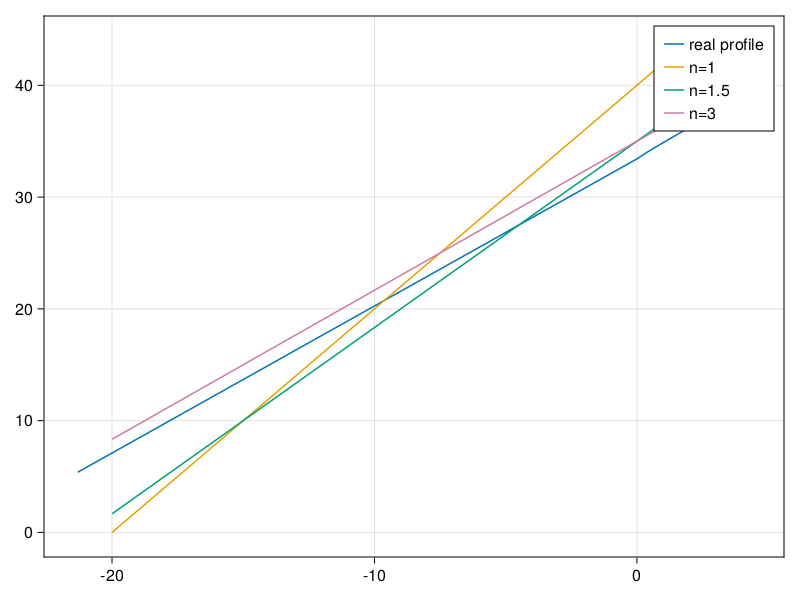

In [17]:
ρprofile = zeros(sm.nz)
for i in 1:sm.nz
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]], sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]], [1.0], [:H1])
    ρprofile[i] = eos_result[1]
end

using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, log.(ρprofile), [sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] for i in 1:sm.nz], label="real profile")
xvals = LinRange(-20,2,100)
lines!(ax,xvals,(1+1/1) .* xvals .+ 40, label="n=1")
lines!(ax,xvals,(1+1/(1.5)) .* xvals .+ 35, label="n=1.5")
lines!(ax,xvals,(1+1/3) .* xvals .+ 35, label="n=3")
axislegend(ax)
f

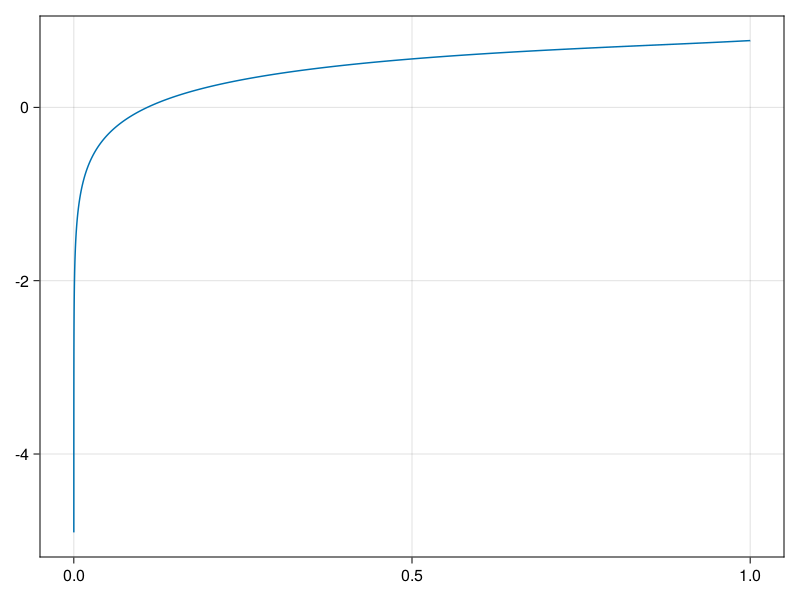

In [18]:
using CairoMakie
f = Figure()
ax = Axis(f[1,1])
lines!(ax, m_face/MSUN, log10.([sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lum]] for i in 1:sm.nz].+1e-20))
f

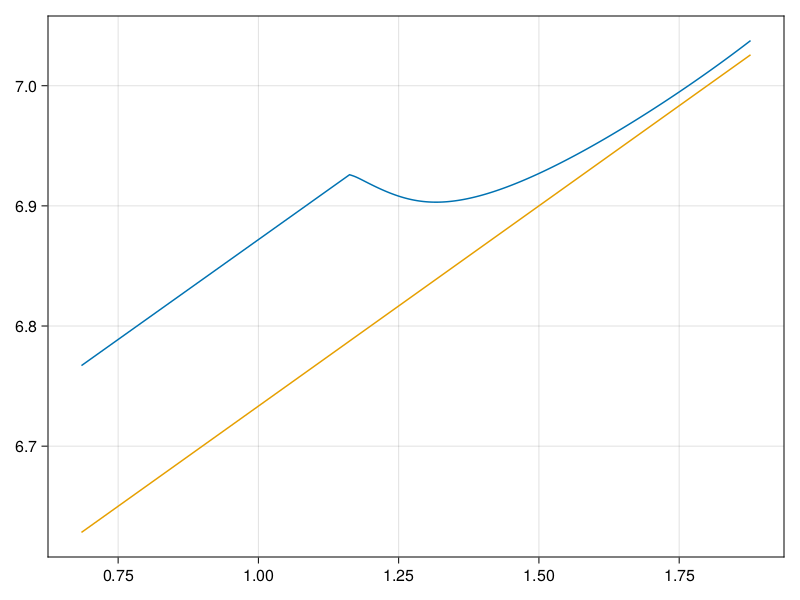

In [19]:
ρcenter = zeros(nsteps)
for i in 1:nsteps
    eos_result = get_EOS_resultsTP(sm.eos, sm.isotope_data,
        log(Tcenter[i]), log(Pcenter[i]), [1.0], [:H1])
    ρcenter[i] = eos_result[1]
end

using CairoMakie
using LaTeXStrings

f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, log10.(ρcenter), log10.(Tcenter))
lines!(ax, log10.(ρcenter), log10.(ρcenter)./3 .+ 6.4)
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f

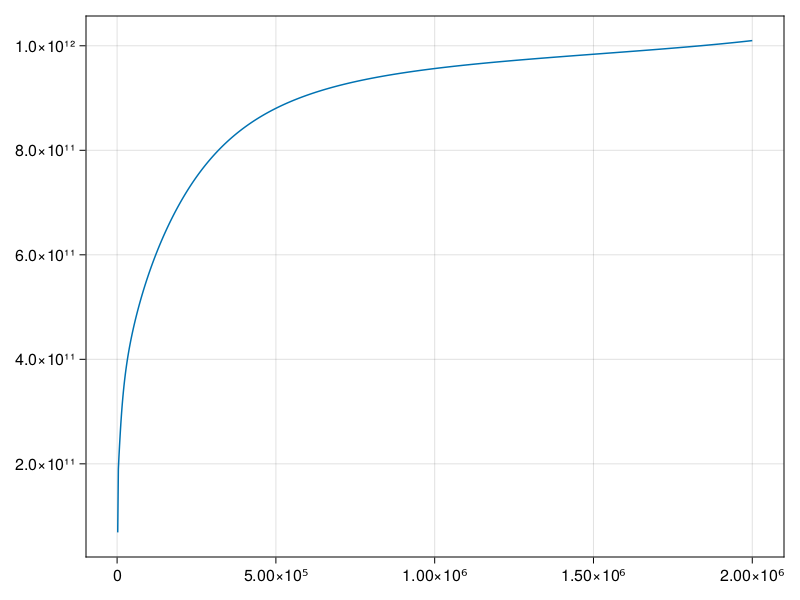

In [22]:
f = Figure()
ax = Axis(f[1,1], xlabel="")
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, times, Pcenter)
lines!(ax, times, Rsurf) # not contracting right now?
#lines!(ax, 1:10000, Lsurf)
#xlims!(ax,930,940)
f

In [6]:
using Profile
Profile.clear()
@profile (for i in 1:1000; StellarEvolution.eval_jacobian!(sm); end)

In [7]:
Profile.print(sortedby=:count, maxdepth=15, mincount=100)

Overhead ╎ [+additional indent] Count File:Line; Function
     ╎350   @Base/client.jl:522; _start()
     ╎ 350   @Base/client.jl:307; exec_options(opts::Base.JLOpt...
     ╎  350   @Base/Base.jl:457; include(mod::Module, _path::...
     ╎   350   @Base/loading.jl:1924; _include(mapexpr::Function,...
     ╎    350   @Base/loading.jl:1864; include_string(mapexpr::typ...
     ╎     350   @Base/boot.jl:370; eval
     ╎    ╎ 350   ...ebook/notebook.jl:32; top-level scope
     ╎    ╎  350   ...erve_notebook.jl:75; kwcall(::NamedTuple{(:cras...
     ╎    ╎   350   ...rve_notebook.jl:139; serve_notebook(pipename::...
     ╎    ╎    350   ...PC/src/typed.jl:67; dispatch_msg(x::VSCodeSer...
     ╎    ╎     350   ...rve_notebook.jl:13; notebook_runcell_request...
     ╎    ╎    ╎ 350   ...er/src/repl.jl:249; withpath(f::VSCodeServe...
     ╎    ╎    ╎  350   ...ve_notebook.jl:19; (::VSCodeServer.var"#19...
     ╎    ╎    ╎   350   ...essentials.jl:813; invokelatest
     ╎    ╎    ╎    350   ...es

     ╎    ╎    422   ...src/jacobian.jl:112; extract_jacobian_chunk!(...
     ╎    ╎     413   ...e/broadcast.jl:881; materialize!
     ╎    ╎    ╎ 413   ...e/broadcast.jl:884; materialize!
     ╎    ╎    ╎  412   ...e/broadcast.jl:926; copyto!
     ╎    ╎    ╎   396   .../broadcast.jl:973; copyto!
     ╎    ╎    ╎    371   ...e/simdloop.jl:77; macro expansion
     ╎    ╎    ╎     371   .../broadcast.jl:974; macro expansion
   10╎    ╎   478   ...src/jacobian.jl:202; chunk_mode_jacobian!(resu...
     ╎    ╎    444   ...src/jacobian.jl:112; extract_jacobian_chunk!(...
     ╎    ╎     437   ...e/broadcast.jl:881; materialize!
     ╎    ╎    ╎ 437   ...e/broadcast.jl:884; materialize!
     ╎    ╎    ╎  436   ...e/broadcast.jl:926; copyto!
     ╎    ╎    ╎   420   .../broadcast.jl:973; copyto!
     ╎    ╎    ╎    391   ...e/simdloop.jl:77; macro expansion
     ╎    ╎    ╎     391   .../broadcast.jl:974; macro expansion
     ╎    ╎   8466  ...src/jacobian.jl:201; chunk_mode_jacobian!(resu..

  122╎    ╎    ╎ 141   ...tingStar.ipynb:52; equationLuminosity(sm:...
  135╎    ╎    ╎ 160   ...tingStar.ipynb:53; equationLuminosity(sm:...
  233╎    ╎    ╎ 240   ...tingStar.ipynb:12; equationHSE(sm::Stella...
  250╎    ╎    ╎ 268   ...tingStar.ipynb:76; equationContinuity(sm:...
  168╎    ╎    ╎ 328   ...tingStar.ipynb:36; equationT(sm::StellarM...
  138╎    ╎    ╎  142   .../operators.jl:578; *
  340╎    ╎    ╎ 355   ...tingStar.ipynb:34; equationT(sm::StellarM...
  341╎    ╎    ╎ 359   ...tingStar.ipynb:54; equationLuminosity(sm:...
  376╎    ╎    ╎ 402   ...tingStar.ipynb:31; equationT(sm::StellarM...
  431╎    ╎    ╎ 475   ...tingStar.ipynb:28; equationT(sm::StellarM...
  497╎    ╎    ╎ 527   ...tingStar.ipynb:16; equationHSE(sm::Stella...
  404╎    ╎    ╎ 664   ...tingStar.ipynb:38; equationT(sm::StellarM...
  212╎    ╎    ╎  223   ...e/operators.jl:578; *
     ╎    ╎   8540  ...src/jacobian.jl:183; chunk_mode_jacobian!(resu...
   24╎    ╎    8540  ...n/src/Solver.jl:97; #3
  

  128╎    ╎    ╎ 161   ...tingStar.ipynb:53; equationLuminosity(sm:...
  191╎    ╎    ╎ 209   ...tingStar.ipynb:52; equationLuminosity(sm:...
  270╎    ╎    ╎ 281   ...tingStar.ipynb:76; equationContinuity(sm:...
  157╎    ╎    ╎ 290   ...tingStar.ipynb:36; equationT(sm::StellarM...
  120╎    ╎    ╎  124   ...e/operators.jl:578; *
  301╎    ╎    ╎ 318   ...tingStar.ipynb:31; equationT(sm::StellarM...
  347╎    ╎    ╎ 363   ...tingStar.ipynb:34; equationT(sm::StellarM...
  363╎    ╎    ╎ 373   ...tingStar.ipynb:54; equationLuminosity(sm:...
  373╎    ╎    ╎ 381   ...tingStar.ipynb:12; equationHSE(sm::Stella...
  360╎    ╎    ╎ 407   ...tingStar.ipynb:28; equationT(sm::StellarM...
  458╎    ╎    ╎ 506   ...tingStar.ipynb:16; equationHSE(sm::Stella...
  479╎    ╎    ╎ 737   ...tingStar.ipynb:38; equationT(sm::StellarM...
  199╎    ╎    ╎  204   ...e/operators.jl:578; *
Total snapshots: 42496. Utilization: 92% across all threads and tasks. Use the `groupby` kwarg to break down by thread an